<a href="https://colab.research.google.com/github/sterzoutt/DS3000A-GROUP/blob/main/DS3000A_GROUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix
)


from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

df = pd.read_csv("diabetes_dataset.csv");
display(df.head())
display(df.shape)

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


(100000, 31)

In [176]:
#Q1.2
#dataset has no null values to replace (good)
df.isnull().sum()

age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0


In [177]:
df['diagnosed_diabetes'].value_counts(normalize = True)
df['diagnosed_diabetes'].value_counts(normalize = False)



diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

In [178]:
X = df.drop('diagnosed_diabetes', axis=1)
y = df['diagnosed_diabetes']


In [179]:
display(y.value_counts(normalize=False))
display(y.value_counts(normalize=True))

diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64

In [180]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df.drop(columns=['diabetes_stage'], axis=1)
df = pd.get_dummies(df, columns=['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 
                                 'smoking_status'], drop_first=True)

correlations_with_target = df.corr()['diagnosed_diabetes'].drop('diagnosed_diabetes')

correlations_with_target = correlations_with_target.sort_values(ascending=False)

corr_df = correlations_with_target.to_frame(name='Correlation with Diagnosed Diabetes')



In [181]:
# initialize an empty list to store the new column order
ordered_columns = []

ordered_columns.append('diagnosed_diabetes')

# iterate through the original DataFrame columns
for col in df.columns:
    if col != 'diagnosed_diabetes':
        ordered_columns.append(col)

# new df with proper ordering
df = df[ordered_columns]
pd.set_option('display.max_columns', None)
display(df.head())

,diagnosed_diabetes,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,gender_Male,gender_Other,ethnicity_Black,ethnicity_Hispanic,ethnicity_Other,ethnicity_White,education_level_Highschool,education_level_No formal,education_level_Postgraduate,income_level_Low,income_level_Lower-Middle,income_level_Middle,income_level_Upper-Middle,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Former,smoking_status_Never
0,1,58,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True
1,0,48,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63,23.0,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False
2,1,60,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,True
3,1,74,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True
4,1,46,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.20,23.5,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True


# Selected Features and Correlation Matrix no barrier = DS1

In [182]:
correlationMatrix = df.corr()

In [183]:
cm = correlationMatrix['diagnosed_diabetes'].sort_values(ascending=False)
print(cm)

diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
diabetes_risk_score                   0.277300
family_history_diabetes               0.197926
age                                   0.137713
bmi                                   0.097057
systolic_bp                           0.095481
waist_to_hip_ratio                    0.078918
ldl_cholesterol                       0.067475
cholesterol_total                     0.058173
insulin_level                         0.057715
triglycerides                         0.056230
diastolic_bp                          0.035619
cardiovascular_history                0.029793
hypertension_history                  0.027524
heart_rate                            0.022785
screen_time_hours_per_day             0.018127
gender_Other                          0.006430
income_level_Lower-Middle             0.004587
ethnicity_Oth

# Selected Features and Correlation Matrix >=0.05 = DS2

In [184]:
selected_features_low = correlationMatrix['diagnosed_diabetes']
selected_features_low = selected_features_low[selected_features_low.abs() >= 0.05]
selected_features_low_list = selected_features_low.sort_values(ascending=False)
print(selected_features_low_list)


diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
diabetes_risk_score                   0.277300
family_history_diabetes               0.197926
age                                   0.137713
bmi                                   0.097057
systolic_bp                           0.095481
waist_to_hip_ratio                    0.078918
ldl_cholesterol                       0.067475
cholesterol_total                     0.058173
insulin_level                         0.057715
triglycerides                         0.056230
hdl_cholesterol                      -0.051227
physical_activity_minutes_per_week   -0.100774
Name: diagnosed_diabetes, dtype: float64


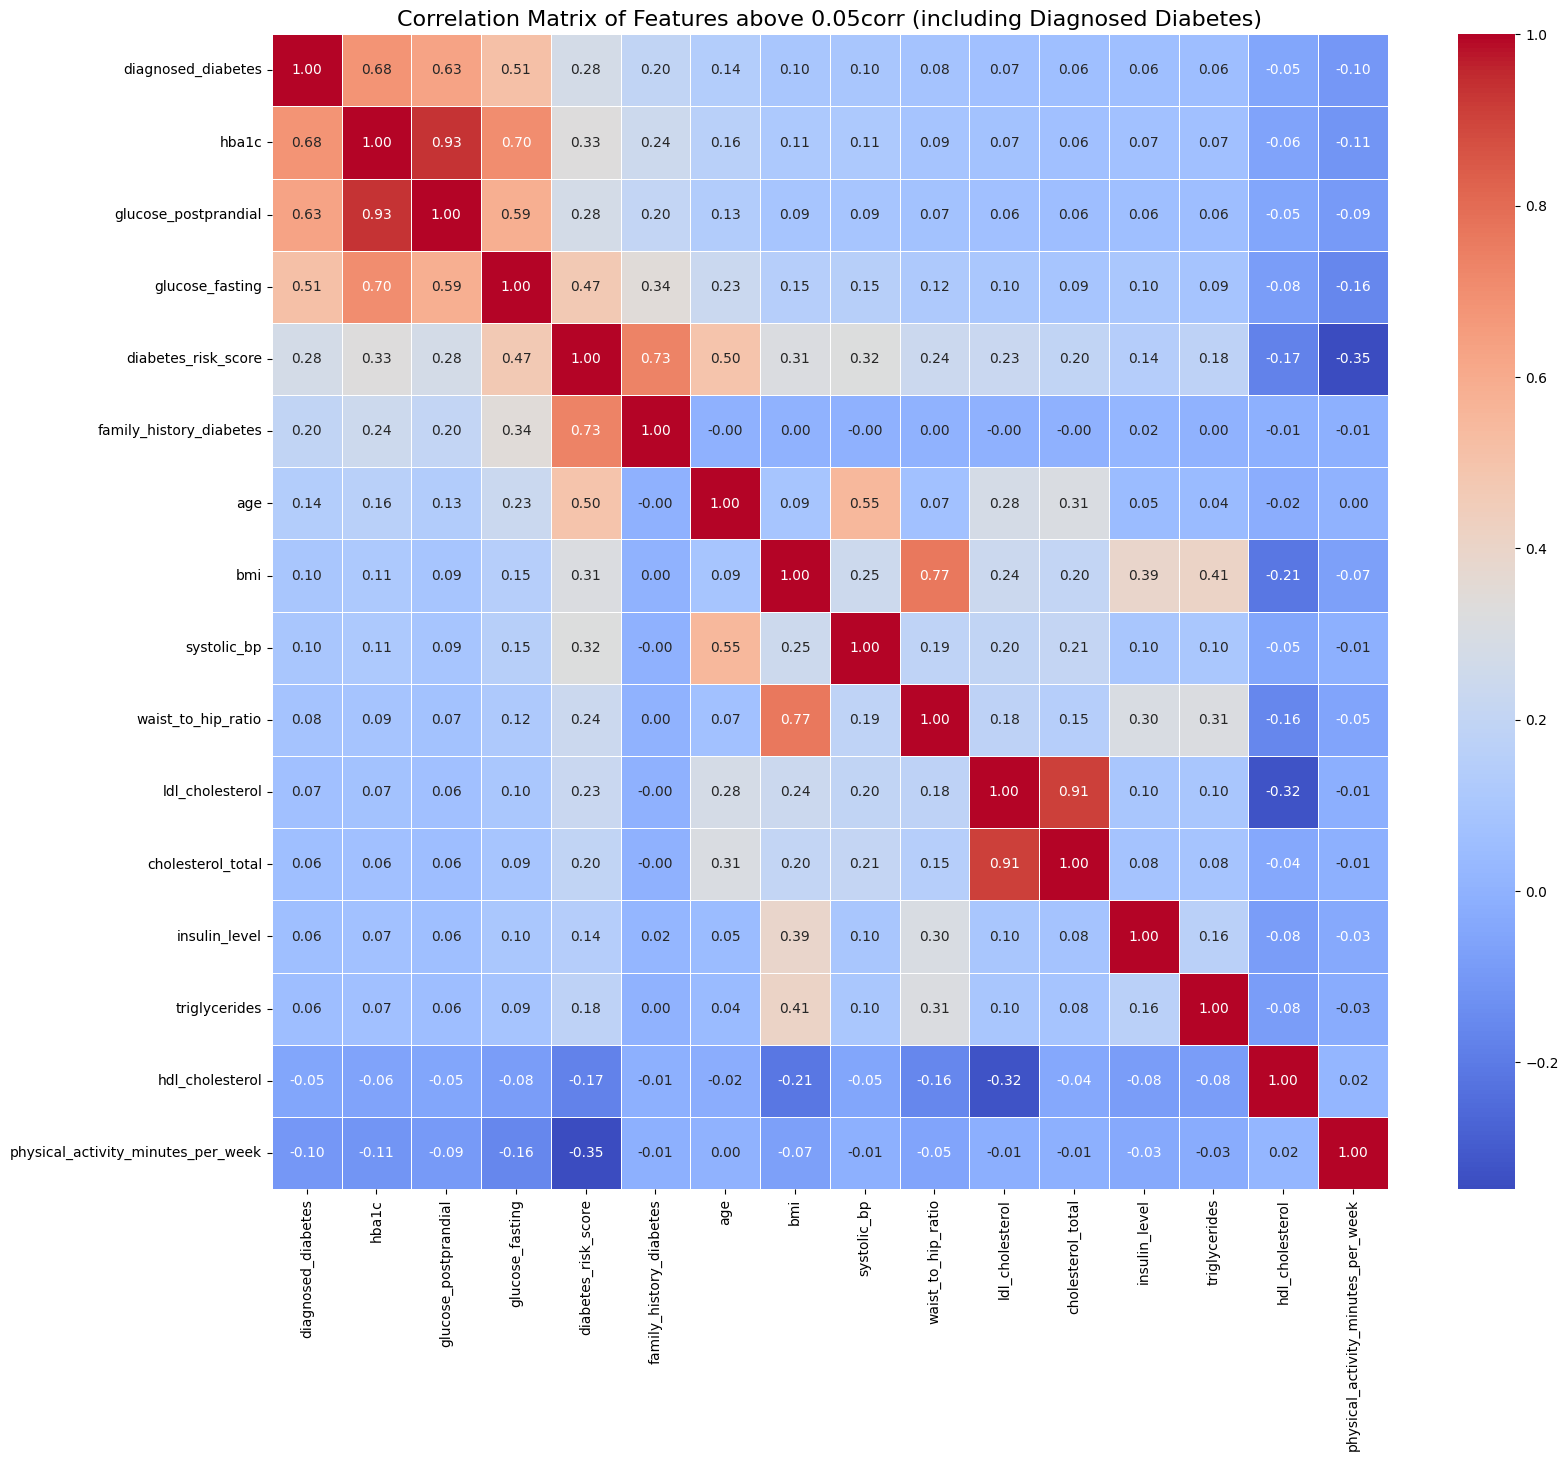

In [185]:
cols = selected_features_low_list.index
correlationMatrix = df[cols].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features above 0.05corr (including Diagnosed Diabetes)', fontsize=16)
plt.show()

# Selected Features and Correlation Matrix >=0.10 = DS3

In [186]:
selected_features_high = correlationMatrix['diagnosed_diabetes']
selected_features_high = selected_features_high[selected_features_high.abs() >= 0.10]
selected_features_high = selected_features_high.sort_values(ascending=False)
print(selected_features_high)

diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
diabetes_risk_score                   0.277300
family_history_diabetes               0.197926
age                                   0.137713
physical_activity_minutes_per_week   -0.100774
Name: diagnosed_diabetes, dtype: float64


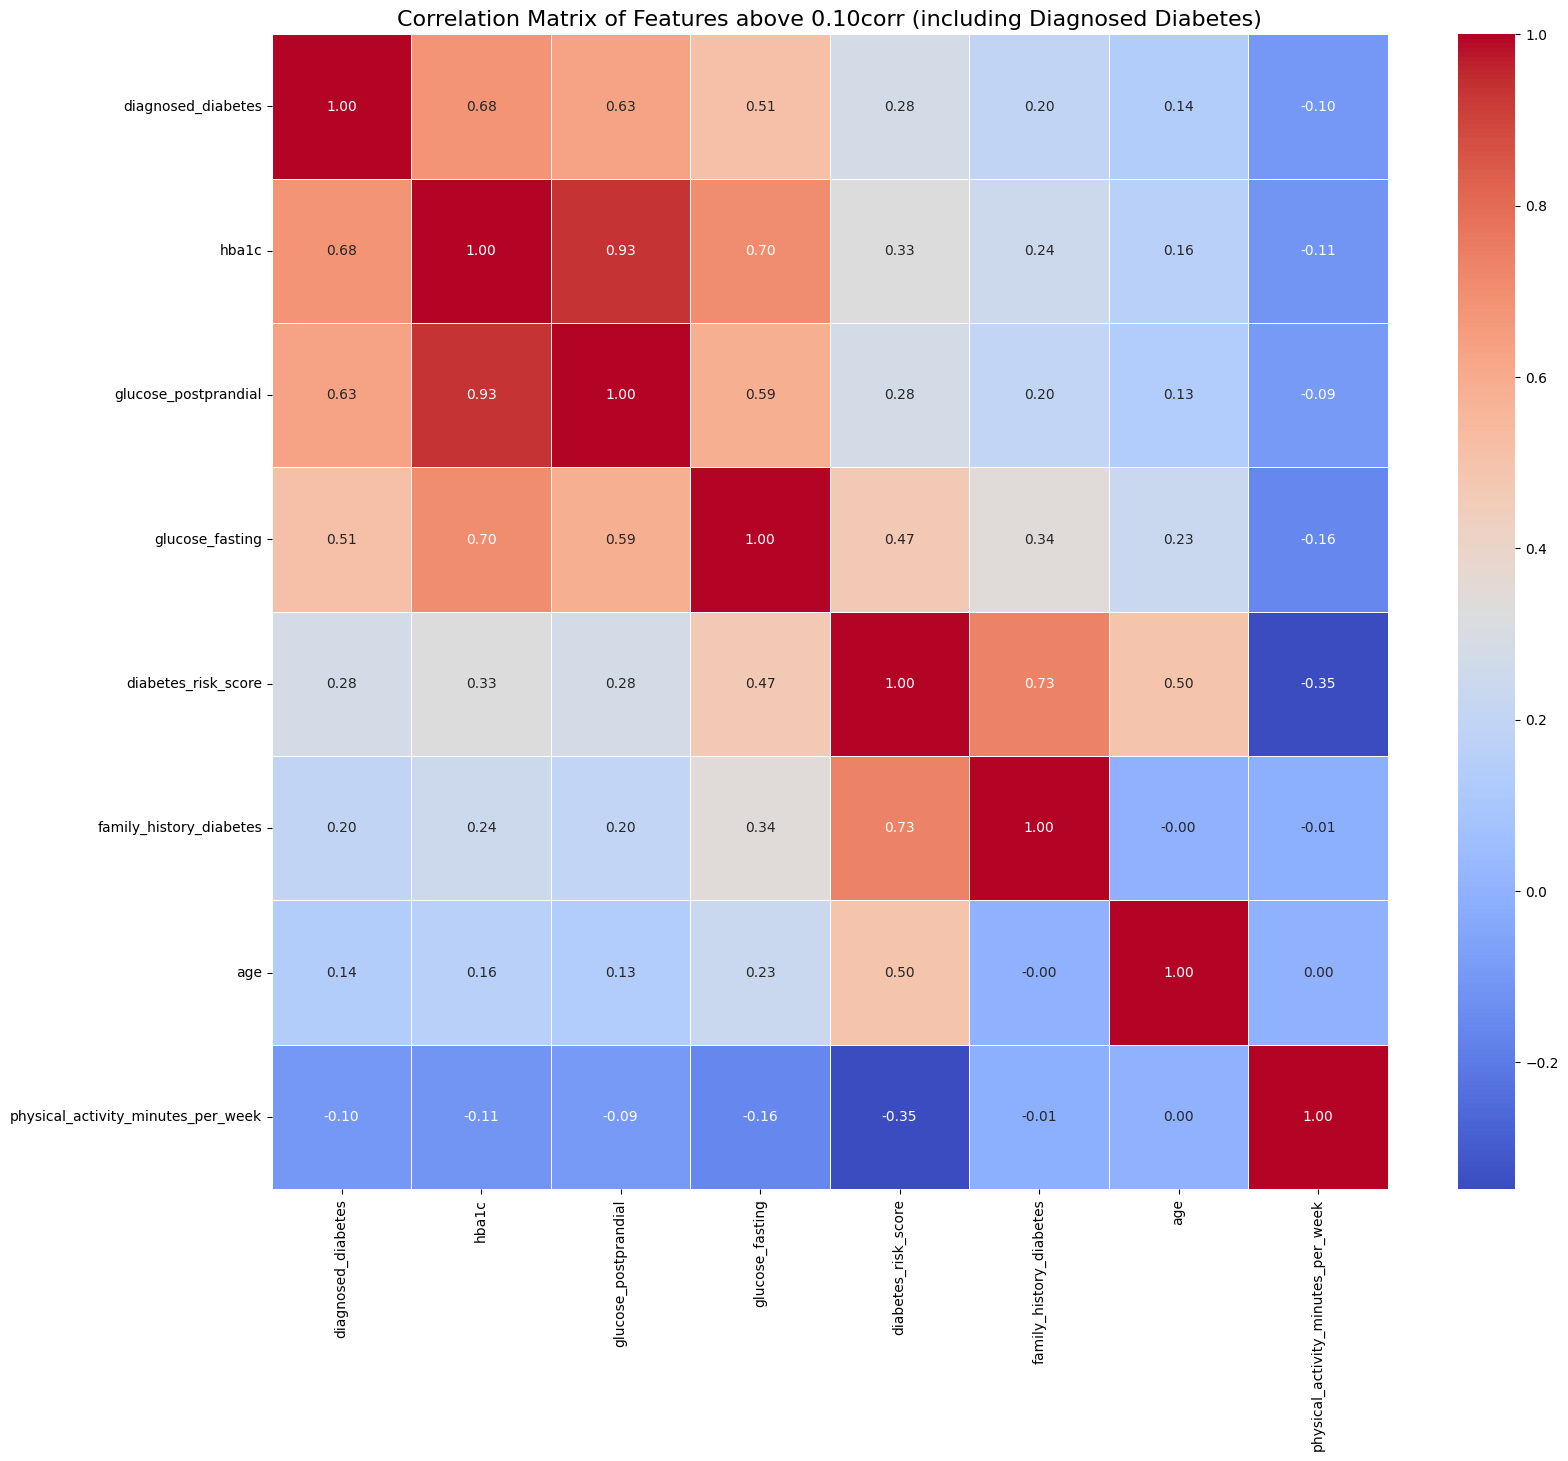

In [187]:
cols = selected_features_high.index
correlationMatrix = df[cols].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features above 0.10corr (including Diagnosed Diabetes)', fontsize=16)
plt.show()

# Logistic Initialization 

In [188]:
def LogisticRegressionInitialization(selected_features_low, features_to_scale):
    cols = selected_features_low.index.difference(['diagnosed_diabetes'])
    X = df[cols]
    y = df['diagnosed_diabetes']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    
    print(X_train.shape)
    print(X_test.shape)
    
    
    
    
    
    scaler = StandardScaler()


    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
    
    
    print("Scaled training data:")
    print(X_train[features_to_scale].head())
    
    print("Scaled test data:")
    print(X_test[features_to_scale].head())
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print(X_train.dtypes)
    print(X_test.dtypes)
    
    lasso = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        max_iter=1000
    )
    
    
    ridge = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000
    )

    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    
    lasso_probs = lasso.predict_proba(X_test)[:, 1]
    lasso_preds = (lasso_probs > 0.5).astype(int)
    
    
    ridge_probs = ridge.predict_proba(X_test)[:, 1]
    ridge_preds = (ridge_probs > 0.5).astype(int)
    
    print("L1 Predictions:", lasso)
    print("L2 Predictions:", ridge)
    
    features = X_train.columns
    
    def evaluate_model(name, y_true, y_pred, y_prob):
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)
        print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {auc:.4f}")
    
    evaluate_model('LASSO Logistic Regression', y_test, lasso_preds, lasso_probs)
    evaluate_model('Ridge Logistic Regression', y_test, ridge_preds, ridge_probs)
    
    # Coefficient comparison
    coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'LASSO Coeff': lasso.coef_[0],
    'Ridge Coeff': ridge.coef_[0]
    })
    
    coeff_df_melted = coeff_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')
    plt.figure(figsize=(10,6))
    sns.barplot(data=coeff_df_melted, x='Feature', y='Coefficient', hue='Model')
    plt.xticks(rotation=45)
    plt.title('Feature Coefficients: LASSO vs Ridge')
    plt.show()

# Logistic Regression DS1

(80000, 41)
(20000, 41)
Scaled training data:
            age  physical_activity_minutes_per_week       bmi  \
27589 -1.865972                            0.128714  0.109490   
84374  1.019899                           -0.567335  0.360223   
69440 -1.288798                            0.211296 -2.955025   
66183 -0.519232                           -0.555537  0.415942   
16613  0.186203                           -0.307791 -0.280539   

       waist_to_hip_ratio  systolic_bp  cholesterol_total  hdl_cholesterol  \
27589           -0.341643     0.294819          -0.092821        -2.148904   
84374            0.084515     1.906492           1.313031         0.190124   
69440           -1.407039    -1.667218          -1.186262        -0.297174   
66183           -0.128564     0.575110           0.938137         1.944395   
16613           -0.341643    -0.826345           0.219590        -1.369228   

       ldl_cholesterol  triglycerides  glucose_fasting  glucose_postprandial  \
27589         

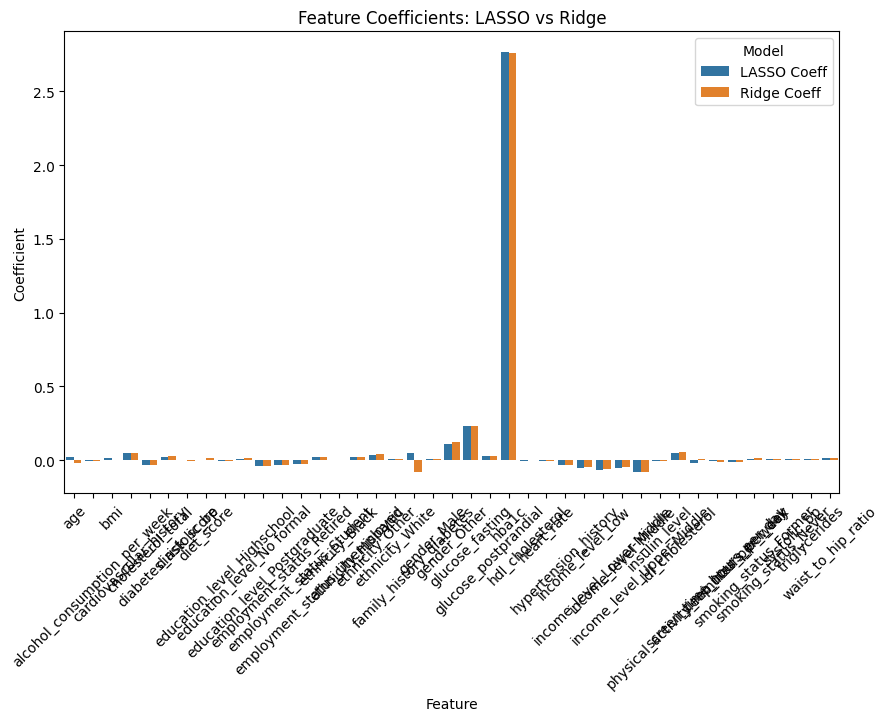

In [189]:
features_to_scale = [
    'age',
    'physical_activity_minutes_per_week',
    'bmi',
    'waist_to_hip_ratio',
    'systolic_bp',
    'cholesterol_total',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'triglycerides',
    'glucose_fasting',
    'glucose_postprandial',
    'insulin_level',
    'hba1c',
    'diet_score',
    'sleep_hours_per_day',
    'screen_time_hours_per_day',
    'diastolic_bp',
    'heart_rate',
]

LogisticRegressionInitialization(cm, features_to_scale)

# Logistic Regression DS2

(80000, 15)
(20000, 15)
Scaled training data:
            age  physical_activity_minutes_per_week       bmi  \
27589 -1.865972                            0.128714  0.109490   
84374  1.019899                           -0.567335  0.360223   
69440 -1.288798                            0.211296 -2.955025   
66183 -0.519232                           -0.555537  0.415942   
16613  0.186203                           -0.307791 -0.280539   

       waist_to_hip_ratio  systolic_bp  cholesterol_total  hdl_cholesterol  \
27589           -0.341643     0.294819          -0.092821        -2.148904   
84374            0.084515     1.906492           1.313031         0.190124   
69440           -1.407039    -1.667218          -1.186262        -0.297174   
66183           -0.128564     0.575110           0.938137         1.944395   
16613           -0.341643    -0.826345           0.219590        -1.369228   

       ldl_cholesterol  triglycerides  glucose_fasting  glucose_postprandial  \
27589         

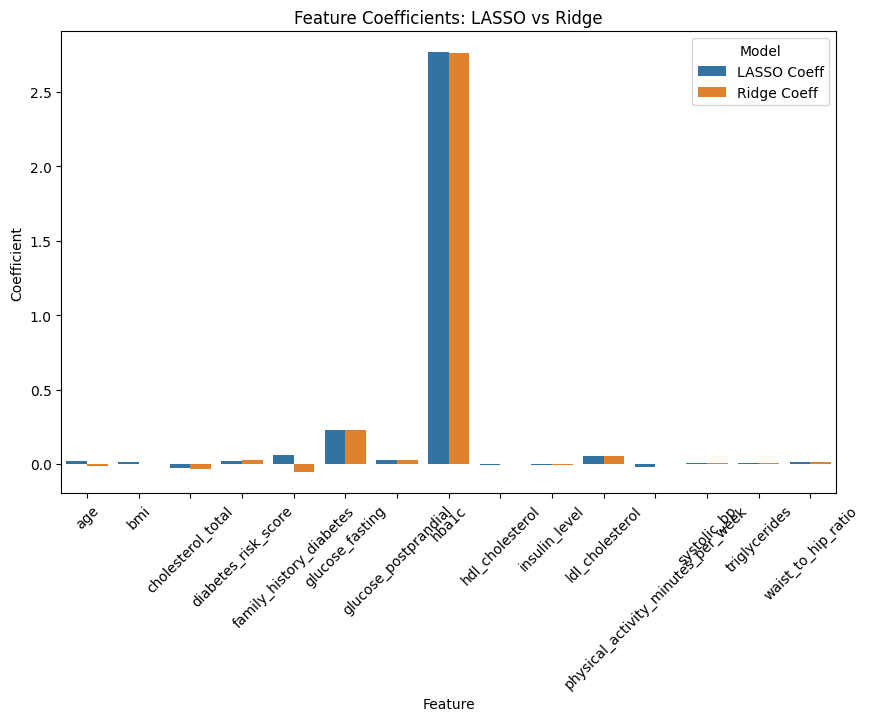

In [190]:
features_to_scale = [
    'age',
    'physical_activity_minutes_per_week',
    'bmi',
    'waist_to_hip_ratio',
    'systolic_bp',
    'cholesterol_total',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'triglycerides',
    'glucose_fasting',
    'glucose_postprandial',
    'insulin_level',
    'hba1c',
]

LogisticRegressionInitialization(selected_features_low, features_to_scale)

# Logistic Regression DS3

(80000, 7)
(20000, 7)
Scaled training data:
            age  physical_activity_minutes_per_week  glucose_fasting  \
27589 -1.865972                            0.128714        -0.375891   
84374  1.019899                           -0.567335         1.611352   
69440 -1.288798                            0.211296         1.390547   
66183 -0.519232                           -0.555537         0.360125   
16613  0.186203                           -0.307791         0.728133   

       glucose_postprandial     hba1c  
27589              0.289025  0.021885  
84374             -0.843218 -0.457752  
69440              1.324219  1.755955  
66183             -1.102016 -0.740614  
16613              2.003564  1.940430  
Scaled test data:
            age  physical_activity_minutes_per_week  glucose_fasting  \
66593  1.981856                            2.110684        -0.007883   
52573  0.442725                           -0.567335         1.022539   
76795 -0.070319                           -1.3341

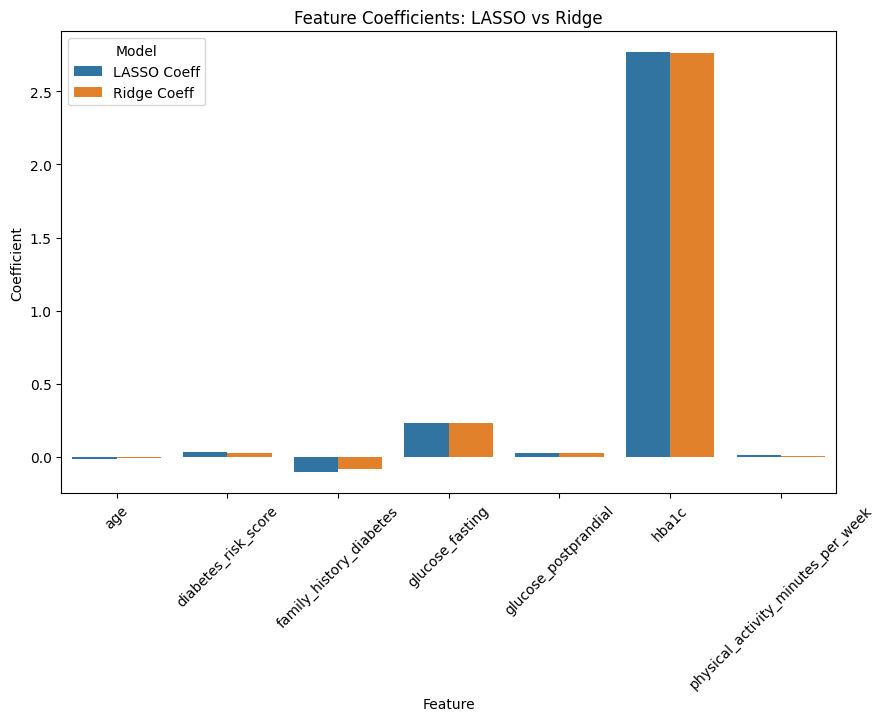

In [191]:
features_to_scale = [
    'age',
    'physical_activity_minutes_per_week',
    'glucose_fasting',
    'glucose_postprandial',
    'hba1c',
]

LogisticRegressionInitialization(selected_features_high, features_to_scale)